In [101]:
import tensorflow as tf 
import keras
from keras.callbacks import *
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot 
from keras.models import Sequential
from keras.layers import *
from keras.preprocessing.image import ImageDataGenerator
import logging, os

In [102]:
traindata = pd.read_csv('/Users/ajones/Documents/asl/sl/sign_mnist_train/sign_mnist_train.csv')

In [103]:
traindata.head(4)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163


In [104]:
traindata.shape

(27455, 785)

In [105]:
trainlabel=traindata['label'].values
traindata.drop('label',inplace=True,axis=1)
trainimages = traindata.values
##inserted images will be (28,28,1)
trainimages = trainimages.reshape(-1,28,28,1)

In [106]:
testdata = pd.read_csv('/Users/ajones/Documents/asl/sl/sign_mnist_test/sign_mnist_test.csv')

In [107]:
testlabel=testdata['label'].values
testdata.drop('label',inplace=True,axis=1)
testimages = testdata.values
testimages=testimages.reshape(-1,28,28,1)

In [108]:
traingen=ImageDataGenerator(rotation_range=20,
                            zoom_range=0.1,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            shear_range=0.1,
                            horizontal_flip=True,
                            rescale=1/255.0,#normalising the data
                            validation_split=0.2 #train_val split
                            )

In [109]:
traindata_generator = traingen.flow(trainimages,trainlabel,subset='training')
validationdata_generator = traingen.flow(trainimages,trainlabel,subset='validation')

In [110]:
testgen=ImageDataGenerator(rescale=1/255.0)

In [111]:
testdata_generator = testgen.flow(testimages,testlabel)

In [112]:
model=Sequential([])

#convulation layer 1
model.add(Conv2D(64,(3,3),activation="relu",input_shape=(28,28,1)))
model.add(MaxPooling2D(2,2))

#convulation layer 2
model.add(Conv2D(128,(3,3),activation="relu"))
model.add(MaxPooling2D(2,2))

model.add(Flatten())
model.add(Dense(256,activation="relu"))
model.add(Dense(26,activation="softmax"))

In [113]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 26, 26, 64)        640       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 13, 13, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 11, 11, 128)       73856     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 5, 5, 128)        0         
 g2D)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 3200)              0         
                                                                 
 dense_10 (Dense)            (None, 256)              

In [114]:
model.compile(loss="sparse_categorical_crossentropy",optimizer='adam',metrics=['accuracy'])

In [115]:
history=model.fit(traindata_generator,epochs=2,validation_data=validationdata_generator)

Epoch 1/2
687/687 [==============================] - 9s 13ms/step - loss: 2.0089 - accuracy: 0.3782 - val_loss: 1.1738 - val_accuracy: 0.6112
Epoch 2/2
687/687 [==============================] - 9s 13ms/step - loss: 0.8668 - accuracy: 0.7168 - val_loss: 0.6756 - val_accuracy: 0.7704


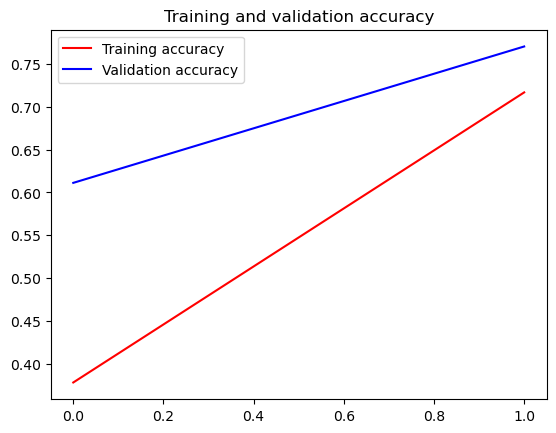

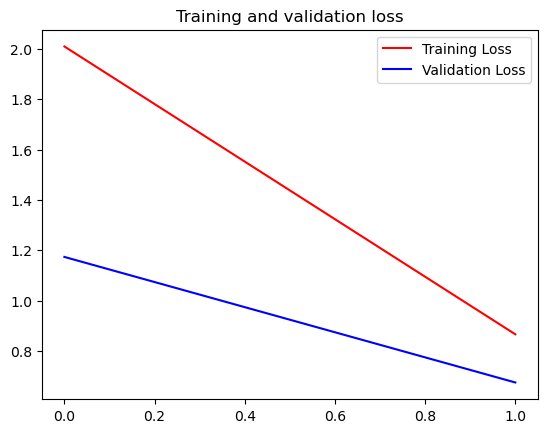

In [119]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy'] 
loss = history.history['loss'] 
val_loss = history.history['val_loss']

epochs = range(len(acc))

pyplot.plot(epochs, acc, 'r', label='Training accuracy') 
pyplot.plot(epochs, val_acc, 'b', label='Validation accuracy') 
pyplot.title('Training and validation accuracy') 
pyplot.legend() 
pyplot.figure()

pyplot.plot(epochs, loss, 'r', label='Training Loss') 
pyplot.plot(epochs, val_loss, 'b', label='Validation Loss') 
pyplot.title('Training and validation loss') 
pyplot.legend()

pyplot.show()

In [120]:
loss,accuracy = model.evaluate(testdata_generator)
print("test accuracy: "+ str(accuracy*100))

225/225 [==============================] - 1s 4ms/step - loss: 0.4524 - accuracy: 0.8335
test accuracy: 83.35192203521729


In [129]:
saved_model_path = "./asl_model"
model.save(saved_model_path)
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
command = f"python -m tf2onnx.convert --saved-model ./asl_model --output asl.onnx"
os.system(command)


/Users/ajones/Documents/asl/env/lib/python3.10/runpy.py:126: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
2023-04-29 19:00:33,998 - WARNING - '--tag' not specified for saved_model. Using --tag serve
2023-04-29 19:00:34,137 - INFO - Signatures found in model: [serving_default].
2023-04-29 19:00:34,137 - WARNING - '--signature_def' not specified, using first signature: serving_default
2023-04-29 19:00:34,137 - INFO - Output names: ['dense_11']
2023-04-29 19:00:34,225 - INFO - Using tensorflow=2.11.1, onnx=1.13.1, tf2onnx=1.14.0/8f8d49
2023-04-29 19:00:34,225 - INFO - Using opset <onnx, 15>
2023-04-29 19:00:34,234 - INFO - Computed 0 values for constant folding
2023-04-29 19:00:34,248 - INFO - Optimizing ONNX model
2023-04-29 19:00:34,306 - INFO - After optimization: Cast -1 (1->0), Const +1 (9->10), Identity -2 (2->0), Reshape +1

0